# WorldClim data : Historical & future Climatologies (1970-2100) - GRAPHS
## 4 SSP scenarios and 9 Global Climatic Models (Precipitation or Temperature)
- Data: https://www.worldclim.org/data/index.html
- author: Loïc Duffar https://github.com/loicduffar

This python notebook uses data from the wordclim web site to compute the evolution of future precipitation on a given watershed (average of the pixels inside the polygon). The ouputs are stored in an excel file.

NOTA: The code can handle precipitation or average temperature

### How to PROCEED ?
The data files must be divided into different sub-folders:
- a folder containing the 12 tif files of historical monthly interannual averages (1 file per month of the year)
- a folder with 4 sub-folders for the various future periods (1921-1940, 1961-1981, 1981-2100). Each folder contains 4 tif files for each model (and each file contains 12 bands for the the different months).

Then run cells in order:
- <a href=#section01>1)</a> Historical Climatology 1970-2000 (interannual monthly mean)
- <a href=#section02>2)</a> Future Climatology
- <a href=#section03>3)</a> Multi index by Model, Scenario and Period
- <a href=#section04>4)</a> Concatenate historical and future climatology in a single dataframe
- <a href=#section05>5)</a> Plot annual evolution of annual climatology in future, according to all SSP scenarios and all GCM
- <a href=#section06>6)</a> Plot future evolution for each month, according to 4 SSP scenarios and 9 GCMs
- <a href=#section07>7)</a> Store statistics in a dataframe
- <a href=#section08>8)</a> Plot montly projections (all SSP scenarios and GCMs)
- <a href=#section09>9)</a> Store all outputs in an excel file

###  <a name=section01></a>1) Historical Climatology 1970-2000
Customize the code below with...
- folder path for historical tif files (it can be precipitation or temperature), 
- folder path for output files, 
- path of the polygon file (folder and file name) for the calculation of the mean water depth

Process started. Please wait the ending message ... 
Process completed in  0:00:02.509809


,1,2,3,4,5,6,7,8,9,10,11,12,Annual
1970-2000 Mean,19.4,19.8,20.7,21.2,21.8,22.2,22.6,22.7,22.5,22.0,20.9,19.8,21.3


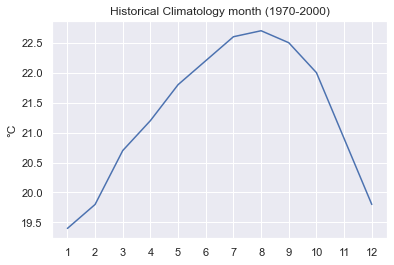

In [32]:
"""
Created on March 2021
@author: Loïc Duffar
"""
import os
import glob2
import rasterstats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# +++++++ Customization
variable= 'Temperature'
file_prefix= 'wc2.1_5m_' # e.g. 'wc2.1_5m_'
# ....... Folder with Historical tif files (FOLDER WITHOUT "\" CHARACTER AT THE END !!!)
fld_in = r'X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat Monde\WorldClim\Historical Climatologies 1970-2000\wc2.1_5m'
# ....... folder path for the output files (WITHOUT "\" CHARACTER AT THE END !!!)
fld_out = r'C:\Users\duffar\Documents\A\ETUDES\2021 Yaque del Sur'
# ....... Polygon file (shape file) for plotting and average computation (path INCLUDING folder)
polygon_file = r'C:\Users\DUFFAR\Documents\A\ETUDES\2021 Yaque del Sur\Carto\Subcuencas_YaqueSur.shp'
historical_period = '1970-2000'

# +++++++ initialisation
annual_label= 'Annual'
baseline_label= historical_period + ' Mean'
if variable.upper()== 'PRECIPITATION':
    file_prefix = file_prefix + 'prec'
    unit= 'mm'
elif variable.upper()== 'TEMPERATURE':
    file_prefix = file_prefix + 't'
    unit= '°C'
        
# +++++++ Polygon averaged
print('Process started. Please wait the ending message ... ')
start= datetime.datetime.now()# Start Timer

results = []
# Loop on raster files (1 file per month)

for month in range(1, 13):
    if variable.upper()== 'PRECIPITATION':
        file = os.path.join(fld_in, file_prefix + '_' + "{:0>2d}".format(month) + '.tif')
    elif variable.upper()== 'TEMPERATURE':
        file = os.path.join(fld_in, file_prefix + 'avg_' + "{:0>2d}".format(month) + '.tif')   
    res = rasterstats.zonal_stats(polygon_file, file, stats=['mean'])
    results.append(round(res[0]['mean'], 1))

df = pd.Series(results, index= range(1, 13), name= baseline_label).to_frame().transpose()
sns.set_theme()
df.transpose().plot(xticks= range(1, 13), grid= True,title= "Historical Climatology month (1970-2000)", ylabel= unit, legend= False)
file_historical = 'WorldClim - historical.png'
plt.savefig(os.path.join(fld_out, file_historical), ) # bbox_inches= 'tight' argument optionnel pour limiter la largeur des marges au minimum nécessaire
if variable.upper()== 'PRECIPITATION':
    df[annual_label] = df.sum(axis= 1)
elif variable.upper()== 'TEMPERATURE':
    df[annual_label] = df.mean(axis= 1)
df_historical= df.copy()
print("Process completed in ", datetime.datetime.now()-start)
display(df_historical)


### <a name=section02></a>2) Future Climatologies
NOTA: Customize the file prefix to handle precipitation or average temperature

Customize the code below with....
- folder path tif files for future data (folder containing 4 sub-folders for the 4 future periods)
- Prefix of the file name (begining of the file name, depending on the parameter, on the version of wordclim data, and on the resolution of the rasters)
- List of the models e.g. ['BCC-CSM2-MR', 'CNRM-CM6-1', ....] (left-middle of the file name)
- List of the SSP scenarios e.g. ['ssp126', 'ssp245', 'ssp370', 'ssp585'] (right-middle of the file name)
- List of the future periods e.g. ['2021-2040', '2041-2060', '2061-2080', '2081-2100'] (end of the file name)

In [34]:
"""
Created on January 2021
@author: Loïc Duffar
"""
import math
import datetime

# +++++++ Customization
# ....... folder path for the tif files (WITHOUT "\" CHARACTER AT THE END !!!)
fld_in = r'X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat Monde\WorldClim\Future data 2021-2100'
# ....... Polygon file (shape file) for plotting and average computation (path INCLUDING folder)
polygon_file = r'C:\Users\DUFFAR\Documents\A\ETUDES\2021 Yaque del Sur\Carto\Subcuencas_YaqueSur.shp'

# ....... Composition of the tif file names
gcm_list = ['BCC-CSM2-MR']#, 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MRI-ESM2-0']
ssp_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
ssp_list_long = ['ssp1-2.6', 'ssp2-4.5', 'ssp3-7.0', 'ssp5-8.5']
period_list = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']

# +++++++ Process
print('Process started. Please wait the ending message ... ')

start= datetime.datetime.now()# Start Timer
series = []
for period in period_list:
    path = fld_in + '/' + period
    print('Period --------------', period)
    for gcm in gcm_list:
        for scenario in ssp_list:
            if variable.upper()== 'PRECIPITATION':
                file = os.path.join(path, '_'.join([file_prefix, gcm, scenario, period]) + '.tif')
            elif variable.upper()== 'TEMPERATURE':
                file = os.path.join(path, '_'.join([file_prefix + 'min', gcm, scenario, period]) + '.tif')
                file2 = os.path.join(path, '_'.join([file_prefix + 'max', gcm, scenario, period]) + '.tif')
            if not os.path.exists(file):
                serie= pd.Series([math.nan for i in range(1, 13)], index= range(1, 13), name= ' '.join([period, scenario, gcm]))
            else:
                results = []
                # Loop over months (1 month by file band)
                for band in range(1, 13):
                    if variable.upper()== 'PRECIPITATION':
                        res = rasterstats.zonal_stats(polygon_file, file, stats=['mean'], band= band)[0]['mean']
                    elif variable.upper()== 'TEMPERATURE':
                        res= rasterstats.zonal_stats(polygon_file, file, stats=['mean'], band= band)[0]['mean']
                        res= res + rasterstats.zonal_stats(polygon_file, file2, stats=['mean'], band= band)[0]['mean']
                        res= res / 2
                    results.append(round(res, 1))
                serie = pd.Series(results, index= range(1, 13), name= ' '.join([period, scenario, gcm]))
            series.append(serie)

df = pd.DataFrame(series)
if variable.upper()== 'PRECIPITATION':
    df[annual_label] = df.sum(axis= 1, skipna= False)
elif variable.upper()== 'TEMPERATURE':
    df[annual_label] = df.mean(axis= 1, skipna= False).round(1)

print("Process completed in ", datetime.datetime.now()-start)
df_future= df.copy()
display(df_future.head())

Process started. Please wait the ending message ... 
Period -------------- 2021-2040
Period -------------- 2041-2060
Period -------------- 2061-2080
Period -------------- 2081-2100
Process completed in  0:00:18.586722


,1,2,3,4,5,6,7,8,9,10,11,12,Annual
2021-2040 ssp126 BCC-CSM2-MR,20.2,20.7,21.4,22.1,22.6,23.0,23.3,23.4,23.3,22.8,21.8,20.7,22.1
2021-2040 ssp245 BCC-CSM2-MR,20.3,20.7,21.4,22.0,22.6,23.1,23.5,23.6,23.5,22.9,21.8,20.9,22.2
2021-2040 ssp370 BCC-CSM2-MR,20.3,20.8,21.6,22.1,22.7,23.1,23.3,23.6,23.5,23.0,21.9,20.8,22.2
2021-2040 ssp585 BCC-CSM2-MR,20.4,20.9,21.5,22.3,22.7,23.2,23.5,23.6,23.6,22.9,22.0,20.9,22.3
2041-2060 ssp126 BCC-CSM2-MR,20.5,20.9,21.7,22.2,22.8,23.1,23.4,23.6,23.4,22.9,22.0,20.8,22.3


### <a name=section03></a>3) Create multi index for the dataframe (by Model, Scenario and Period)

In [35]:
"""
Created on January 2021
@author: Loïc Duffar
"""
df_future['Period']= df.index.str[0:9]
df_future['Scenario']= df.index.str[10:16]
df_future['Model']= df.index.str[16:]
df_future.set_index(keys= ['Model', 'Scenario', 'Period'], drop= True, inplace=True)
df_future.sort_index(inplace= True)
df_future.head()

1     2     3     4     5     6     7  \
Model        Scenario Period                                                
 BCC-CSM2-MR ssp126   2021-2040  20.2  20.7  21.4  22.1  22.6  23.0  23.3   
                      2041-2060  20.5  20.9  21.7  22.2  22.8  23.1  23.4   
                      2061-2080  20.6  20.9  21.8  22.3  22.9  23.3  23.6   
                      2081-2100  20.3  20.9  21.7  22.2  22.7  23.2  23.5   
             ssp245   2021-2040  20.3  20.7  21.4  22.0  22.6  23.1  23.5   

                                    8     9    10    11    12  Annual  
Model        Scenario Period                                           
 BCC-CSM2-MR ssp126   2021-2040  23.4  23.3  22.8  21.8  20.7    22.1  
                      2041-2060  23.6  23.4  22.9  22.0  20.8    22.3  
                      2061-2080  23.7  23.6  23.1  22.1  21.0    22.4  
                      2081-2100  23.5  23.5  23.0  21.9  20.8    22.3  
             ssp245   2021-2040  23.6  23.5  22.9  21.8  20.9    22.2

### <a name=section04></a>4) Concatenate historical and future precipitation in a single dataframe, and save it in an excel file

In [36]:
"""
Created on January 2021
@author: Loïc Duffar
"""
df_historical= df_historical.copy()
df_historical['Model']= ''
df_historical['Scenario']= 'Historical'
df_historical['Period']= historical_period
df_historical.set_index(keys= ['Model', 'Scenario', 'Period'], inplace= True, drop= True)
df_total= df_future.append(df_historical)
df_total= df_total.sort_index()
display(df_total)

1     2     3     4     5     6     7  \
Model        Scenario   Period                                                
             Historical 1970-2000  19.4  19.8  20.7  21.2  21.8  22.2  22.6   
 BCC-CSM2-MR ssp126     2021-2040  20.2  20.7  21.4  22.1  22.6  23.0  23.3   
                        2041-2060  20.5  20.9  21.7  22.2  22.8  23.1  23.4   
                        2061-2080  20.6  20.9  21.8  22.3  22.9  23.3  23.6   
                        2081-2100  20.3  20.9  21.7  22.2  22.7  23.2  23.5   
             ssp245     2021-2040  20.3  20.7  21.4  22.0  22.6  23.1  23.5   
                        2041-2060  20.6  21.2  22.0  22.5  23.0  23.5  23.8   
                        2061-2080  21.0  21.6  22.3  22.7  23.4  23.7  23.9   
                        2081-2100  21.3  21.8  22.6  23.1  23.6  24.1  24.3   
             ssp370     2021-2040  20.3  20.8  21.6  22.1  22.7  23.1  23.3   
                        2041-2060  21.0  21.3  22.3  22.8  23.3  23.7  24.0   
                        2061-2080  21.6  22.0  22.8  23.4  23.9  24.3  24.6   
                        2081-2100  22.1  22.6  23.4  23.9  24.5  24.9  25.2   
             ssp585     2021-2040  20.4  20.9  21.5  22.3  22.7  23.2  23.5   
                        2041-2060  21.0  21.4  22.1  22.9  23.4  23.8  24.0   
                        2061-2080  21.8  22.1  23.1  23.5  24.1  24.5  24.8   
                        2081-2100  22.4  22.9  23.7  24.2  24.8  25.1  25.3   

                                      8     9    10    11    12  Annual  
Model        Scenario   Period                                           
             Historical 1970-2000  22.7  22.5  22.0  20.9  19.8    21.3  
 BCC-CSM2-MR ssp126     2021-2040  23.4  23.3  22.8  21.8  20.7    22.1  
                        2041-2060  23.6  23.4  22.9  22.0  20.8    22.3  
                        2061-2080  23.7  23.6  23.1  22.1  21.0    22.4  
                        2081-2100  23.5  23.5  23.0  21.9  20.8    22.3  
             ssp245     2021-2040  23.6  23.5  22.9  21.8  20.9    22.2  
                        2041-2060  23.8  23.7  23.2  22.3  21.2    22.6  
                        2061-2080  24.1  24.2  23.6  22.6  21.4    22.9  
                        2081-2100  24.5  24.4  23.8  23.0  21.8    23.2  
             ssp370     2021-2040  23.6  23.5  23.0  21.9  20.8    22.2  
                        2041-2060  24.2  24.1  23.6  22.6  21.5    22.9  
                        2061-2080  24.8  24.8  24.1  23.2  22.1    23.5  
                        2081-2100  25.5  25.5  24.8  23.9  22.7    24.1  
             ssp585     2021-2040  23.6  23.6  22.9  22.0  20.9    22.3  
                        2041-2060  24.2  24.2  23.6  22.6  21.6    22.9  
                        2061-2080  24.9  25.0  24.4  23.4  22.3    23.7  
                        2081-2100  25.7  25.7  25.1  24.0  22.9    24.3

### <a name=section05></a>5) Plot future evolution of annual precipitation/temperature (all scenarios and all GCMs)

In [46]:
"""
Created on January 2021
@author: Loïc Duffar
"""
import plotly.graph_objects as go
import plotly
print('Plotly version: ', plotly.__version__)

#============== Customization
#------------ Name of the dataframe column to plot (e.g. annual or one of month number 1-12) 
month_or_year = annual_label

#============== Process
rgba_list= ['rgba(10, 10, 150, 0.2)', 'rgba(255, 10, 10, 0.1)', 'rgba(10, 150, 10, 0.1)', 'rgba(200, 200, 0, 0.2)']
rgb_list= ['rgb(10, 10, 150)', 'rgb(150, 10, 10)', 'rgb(10, 150, 10)', 'rgb(250, 170, 60)']

x = [historical_period] + ['2021-2040', '2041-2060', '2061-2080', '2081-2100']
fig = go.Figure()
    
for scenario, scenario_long, rgb, rgba in zip(ssp_list, ssp_list_long, rgb_list, rgba_list):
    test= (df_total.index.get_level_values('Scenario') == scenario) | (df_total.index.get_level_values('Scenario') =='Historical')
    group = df_total[test ][month_or_year].groupby(by= ['Period'])
    ymedian= group.median() 
    ymin= group.min()
    ymax= group.max()

    fig.add_trace(
        go.Scatter(
                    name= scenario_long + ' Median of ' + str(len(gcm_list)) + ' GCMs',
                    x= x,
                    y= ymedian,
                    mode= 'lines',
                    line= dict(color= rgb),
                    legendgroup= scenario,
                ))

    fig.add_trace(
        go.Scatter(
                    name= scenario_long + ' Min.',
                    x= x,
                    y= ymin,
                    mode= 'lines',
                    line= dict(width= 0),
                    legendgroup= scenario,            
                    hoverlabel= dict(bgcolor= rgb, font_color='white'),
                    showlegend= False,
                    marker= dict(color= "#444"),
#                     fillcolor= rgba,
#                     fill= 'tonexty',
                    ))
    fig.add_trace(
        go.Scatter(
                    name= scenario_long + ' Min.Max.',
                    x= x,
                    y= ymax,
                    mode= 'lines',
                    line= dict(width= 0),
                    legendgroup= scenario,            
                    hoverlabel= dict(bgcolor= rgb, font_color='white'),
                    showlegend= True,
                    marker= dict(color= "#444"),
                    fillcolor= rgba,
                    fill= 'tonexty',
                    ))

if variable.upper()== 'PRECIPITATION':
    ylegend= 0.05
    yanchor= "bottom"
elif variable.upper()== 'TEMPERATURE':
    ylegend= 0.95
    yanchor= "top"
fig.update_layout(
    height= 700, width= 1000,
    yaxis_title= unit,
    title= 'Evolution of future ' + variable + ' Climatology, according to ' + str(len(ssp_list)) + ' scenarios and ' + str(len(gcm_list)) + ' GCMs',
#    hovermode= "x",
    yaxis_range= [df_total.min().max(), df_total.max().max()],
    legend=dict(yanchor= yanchor,
                y= ylegend,
                xanchor= 'left',
                x= 0.05),
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
#    paper_bgcolor='rgba(0,0,0,0)',
#    plot_bgcolor='rgba(0,0,0,0)',
    )
file_future_by_year= 'WorldClim - future by year.png'
fig.write_image(os.path.join(fld_out, file_future_by_year))# needs installation of "plotly-orca" or "kaleido"
fig.show()

Plotly version:  4.14.1


### <a name=section06></a>6) Plot future evolution for each month (all scenarios and all GCMs)

In [45]:
import plotly.subplots as ps

fig = ps.make_subplots(rows= 4, cols= 3,
                       shared_xaxes=True,
                       vertical_spacing=0.05,
                       subplot_titles= range(1, 13)
                      )

month= 0
for rw in range(1, 5):
    for cl in range(1, 4):
        showlegend= True if month== 0 else False
        month = month + 1
        for scenario, scenario_long, rgb, rgba in zip(ssp_list, ssp_list_long, rgb_list, rgba_list):
            test= (df_total.index.get_level_values('Scenario') == scenario) | (df_total.index.get_level_values('Scenario') =='Historical')
            group = df_total[test ][month].groupby(by= 'Period')

            fig.add_trace(
                go.Scatter(
                    name= scenario_long + ' (' + str(len(gcm_list)) + ' GCMs median)',
                    x= x,
                    y= group.median(),
                    mode= 'lines',
                    line= dict(color= rgb),
                    legendgroup= scenario,
                    showlegend= showlegend,
#                    yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                        ),
                    row= rw, col= cl
                    )

fig.update_layout(
    height= 800, width= 1000,
    yaxis_title= unit,
    title= 'Evolution of future Monthly ' + variable +  ' Climatology, according to ' + str(len(ssp_list)) + ' scenarios (median of ' + str(len(gcm_list)) + ' GCMs)',
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
    hovermode= "x",
#    yaxis_range= [df_total.min().max(), df_total.max().max()],
#    legend= dict(orientation= 'h', yanchor= "top", y= -0.1, xanchor= "left", x= 0.05),
    showlegend= True,
    )
for ax in fig['layout']:
    if ax[:5]== 'yaxis':
        if ax[5:] in ['1', '4', '7', '10']:
            fig['layout'][ax]['title']= unit
file_future_by_month= 'WorldClim - future by month.png'
fig.write_image(os.path.join(fld_out, file_future_by_month))# needs installation of "plotly-orca" or "kaleido"
fig.show()

### <a name=section07></a>7) Create a dataframe with statistics

In [40]:
"""
Created on February 2021
@author: Loïc Duffar
"""
import plotly.graph_objects as go

#============== Customization
#------------ 


#============== Process
df = df_total[0:0]
#display(df)
    
for scenario in ssp_list:
    test= (df_total.index.get_level_values('Scenario') == scenario) 
    group = df_total[test ].groupby(by= ['Period'])
    df_median= group.median().round(1)
#    display(scenario, df_median.reset_index(drop= True))
    df_min= group.min().round(1)
    df_max= group.max().round(1)
    temp= [[scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ]
    temp= [['Max', 'Max', 'Max', 'Max']] + temp
#    print(temp)
    df= df.append(pd.DataFrame(df_max.values, index= [['Max', 'Max', 'Max', 'Max'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ] ))
    df= df.append(pd.DataFrame(df_median.values, index= [['Median', 'Median', 'Median', 'Median'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ]))
    df= df.append(pd.DataFrame(df_min.values, index= [['Min', 'Min', 'Min', 'Min'], [scenario, scenario, scenario, scenario], [period_list[0], period_list[1], period_list[2], period_list[3]] ] ))
df_stat= df.sort_index().copy()
df_stat.drop(columns= annual_label, inplace= True)
df_stat.rename(columns= {0:1, 1:2,2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:annual_label}, inplace= True)
#df_stat= df_future.append(df_historical)
df_stat

1     2     3     4     5     6     7     8  \
Model  Scenario Period                                                      
Max    ssp126   2021-2040  20.2  20.7  21.4  22.1  22.6  23.0  23.3  23.4   
                2041-2060  20.5  20.9  21.7  22.2  22.8  23.1  23.4  23.6   
                2061-2080  20.6  20.9  21.8  22.3  22.9  23.3  23.6  23.7   
                2081-2100  20.3  20.9  21.7  22.2  22.7  23.2  23.5  23.5   
       ssp245   2021-2040  20.3  20.7  21.4  22.0  22.6  23.1  23.5  23.6   
                2041-2060  20.6  21.2  22.0  22.5  23.0  23.5  23.8  23.8   
                2061-2080  21.0  21.6  22.3  22.7  23.4  23.7  23.9  24.1   
                2081-2100  21.3  21.8  22.6  23.1  23.6  24.1  24.3  24.5   
       ssp370   2021-2040  20.3  20.8  21.6  22.1  22.7  23.1  23.3  23.6   
                2041-2060  21.0  21.3  22.3  22.8  23.3  23.7  24.0  24.2   
                2061-2080  21.6  22.0  22.8  23.4  23.9  24.3  24.6  24.8   
                2081-2100  22.1  22.6  23.4  23.9  24.5  24.9  25.2  25.5   
       ssp585   2021-2040  20.4  20.9  21.5  22.3  22.7  23.2  23.5  23.6   
                2041-2060  21.0  21.4  22.1  22.9  23.4  23.8  24.0  24.2   
                2061-2080  21.8  22.1  23.1  23.5  24.1  24.5  24.8  24.9   
                2081-2100  22.4  22.9  23.7  24.2  24.8  25.1  25.3  25.7   
Median ssp126   2021-2040  20.2  20.7  21.4  22.1  22.6  23.0  23.3  23.4   
                2041-2060  20.5  20.9  21.7  22.2  22.8  23.1  23.4  23.6   
                2061-2080  20.6  20.9  21.8  22.3  22.9  23.3  23.6  23.7   
                2081-2100  20.3  20.9  21.7  22.2  22.7  23.2  23.5  23.5   
       ssp245   2021-2040  20.3  20.7  21.4  22.0  22.6  23.1  23.5  23.6   
                2041-2060  20.6  21.2  22.0  22.5  23.0  23.5  23.8  23.8   
                2061-2080  21.0  21.6  22.3  22.7  23.4  23.7  23.9  24.1   
                2081-2100  21.3  21.8  22.6  23.1  23.6  24.1  24.3  24.5   
       ssp370   2021-2040  20.3  20.8  21.6  22.1  22.7  23.1  23.3  23.6   
                2041-2060  21.0  21.3  22.3  22.8  23.3  23.7  24.0  24.2   
                2061-2080  21.6  22.0  22.8  23.4  23.9  24.3  24.6  24.8   
                2081-2100  22.1  22.6  23.4  23.9  24.5  24.9  25.2  25.5   
       ssp585   2021-2040  20.4  20.9  21.5  22.3  22.7  23.2  23.5  23.6   
                2041-2060  21.0  21.4  22.1  22.9  23.4  23.8  24.0  24.2   
                2061-2080  21.8  22.1  23.1  23.5  24.1  24.5  24.8  24.9   
                2081-2100  22.4  22.9  23.7  24.2  24.8  25.1  25.3  25.7   
Min    ssp126   2021-2040  20.2  20.7  21.4  22.1  22.6  23.0  23.3  23.4   
                2041-2060  20.5  20.9  21.7  22.2  22.8  23.1  23.4  23.6   
                2061-2080  20.6  20.9  21.8  22.3  22.9  23.3  23.6  23.7   
                2081-2100  20.3  20.9  21.7  22.2  22.7  23.2  23.5  23.5   
       ssp245   2021-2040  20.3  20.7  21.4  22.0  22.6  23.1  23.5  23.6   
                2041-2060  20.6  21.2  22.0  22.5  23.0  23.5  23.8  23.8   
                2061-2080  21.0  21.6  22.3  22.7  23.4  23.7  23.9  24.1   
                2081-2100  21.3  21.8  22.6  23.1  23.6  24.1  24.3  24.5   
       ssp370   2021-2040  20.3  20.8  21.6  22.1  22.7  23.1  23.3  23.6   
                2041-2060  21.0  21.3  22.3  22.8  23.3  23.7  24.0  24.2   
                2061-2080  21.6  22.0  22.8  23.4  23.9  24.3  24.6  24.8   
                2081-2100  22.1  22.6  23.4  23.9  24.5  24.9  25.2  25.5   
       ssp585   2021-2040  20.4  20.9  21.5  22.3  22.7  23.2  23.5  23.6   
                2041-2060  21.0  21.4  22.1  22.9  23.4  23.8  24.0  24.2   
                2061-2080  21.8  22.1  23.1  23.5  24.1  24.5  24.8  24.9   
                2081-2100  22.4  22.9  23.7  24.2  24.8  25.1  25.3  25.7   

                              9    10    11    12  Annual  
Model  Scenario Period                                     
Max    ssp126   2021-2040  23.3  22.8  21.8  20.7    22.1  

### <a name=section07></a>8) Plot montly projections (all scenarios and GCMs)

In [44]:
"""
Created on February 2021
@author: Loïc Duffar
"""
# Initialisation
showlegend= True
alpha_list=[1, 0.75, 0.5, 0.3, 0.1]

# Plot
x= df_stat.columns.to_list()[:-1]
y_historical= df_historical[:].values[0][:-1]

fig = ps.make_subplots(rows= 4, cols= 1,
                       shared_xaxes= False,
                       vertical_spacing= 0.05,
                       subplot_titles= ssp_list_long
                      )

rw= 0
for scenario, rgb, rgba in zip(ssp_list, rgb_list, rgba_list):
    showlegend_historical= True if rw==0 else False
    rw= rw + 1
    fig.add_trace(
        go.Scatter(
                    name= baseline_label,
                    x= x,
                    y= y_historical,
                    mode= 'lines+markers',
                    line= dict(color= 'rgba(0,0,0,0.5)'),
                    marker= dict(color= 'rgba(0,0,0,0)', line= dict(color='rgba(0,0,0,0.5)', width= 1)),
                    legendgroup= baseline_label,
                    showlegend= showlegend_historical,
        #            yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                        ),
                    row= rw, col= 1
                    )

    for period, alpha in zip(period_list, alpha_list):
        rgba= 'rgba' + rgb[3:-1] + ',' + str(alpha) + ')'
        y= df_stat.loc[('Median', scenario, period)].values[:-1]
        fig.add_trace(
            go.Scatter(
                        name= period + ' ' + scenario,
                        x= x,
                        y= y,
                        mode= 'lines',
                        line= dict(color= rgba),
                        legendgroup= period,
                        showlegend= showlegend,
        #                yaxis= dict(range= [df_total[test ][month].min(), df_total[test ][month].max()]),
                            ),        
                        row= rw, col= 1
                        )

fig.update_layout(
    height= 900, width= 800,
    yaxis_title= unit,
    title= 'Monthly projections for each future period and each scenario (median of ' + str(len(gcm_list)) +' GCMs)',
    template= "plotly", # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
    hovermode= "x",
#    xaxis1 = dict(tickvals = x), xaxis2 = dict(tickvals = x), xaxis3 = dict(tickvals = x), xaxis4 = dict(tickvals = x), 
#    yaxis_range= [df_total.min().max(), df_total.max().max()],
#    legend= dict(orientation= 'h', yanchor= "top", y= -0.1, xanchor= "left", x= 0.05),
    showlegend= True,
    )

for ax in fig['layout']:
    if ax[:5]== 'xaxis':
        fig['layout'][ax]['tickvals']= x
    if ax[:5]== 'yaxis':
        fig['layout'][ax]['title']= unit

file_future_by_scenario= 'WorldClim - future by scenario.png'
fig.write_image(os.path.join(fld_out, file_future_by_scenario))# needs installation of "plotly-orca" or "kaleido"
fig.show()

### <a name=section08></a>9) Store outputs in excel file

In [9]:

writer = pd.ExcelWriter(os.path.join(fld_out, 'worldclim - output.xlsx'), engine= 'xlsxwriter')
workbook  = writer.book
df_total.to_excel(writer, sheet_name='Data')
df_stat.to_excel(writer, sheet_name='Stat')
worksheet = writer.sheets['Data']
if os.path.exists(os.path.join(fld_out, file_historical)):
    worksheet.insert_image('R1', os.path.join(fld_out, file_historical))

worksheet = workbook.add_worksheet('Graph')
if os.path.exists(os.path.join(fld_out, file_future_by_year)):
    worksheet.insert_image('A1', os.path.join(fld_out, file_future_by_year))
if os.path.exists(os.path.join(fld_out, file_future_by_month)):
    worksheet.insert_image('P1', os.path.join(fld_out, file_future_by_month))
if os.path.exists(os.path.join(fld_out, file_future_by_scenario)):
    worksheet.insert_image('A36', os.path.join(fld_out, file_future_by_scenario))
writer.save()